### Imports

In [1]:
import cupy as cp
import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from typing import Tuple, List, Dict
from scipy.stats import ttest_rel, wilcoxon
from concurrent.futures import ThreadPoolExecutor

### Definitions

In [ ]:
class SubsystemQuantumTomographyGenerator:
    def __init__(self, total_qubits: int, subsystem_size: int, subsystem_indices: List[int], dataset_size: int, shots_per_setting: int = 1000, depolarizing_noise: float = 0.001, readout_error: float = 0.02, crosstalk_error: float = 0.005, thermal_population: float = 0.01, seed: int = None, temp_dir: str = "temp_data", batch_size: int = 32, gpu_id: int = 0):
        assert subsystem_size <= 10, "Subsystem size must be ≤10 for full tomography"
        assert len(subsystem_indices) == subsystem_size
        assert max(subsystem_indices) < total_qubits
        
        self.total_qubits = total_qubits
        self.subsystem_size = subsystem_size
        self.subsystem_indices = sorted(subsystem_indices)
        self.use_position_encoding = True
        self.position_encoding_dim = 16
        self.position_encoding = self._compute_position_encoding()
        self.dataset_size = dataset_size
        self.shots_per_setting = shots_per_setting
        self.depolarizing_noise = depolarizing_noise
        self.readout_error = readout_error
        self.crosstalk_error = crosstalk_error
        self.thermal_population = thermal_population

        self.subsystem_dim = 2 ** subsystem_size
        
        self.temp_dir = temp_dir
        self.batch_size = batch_size
        self.seed = seed
        
        os.makedirs(temp_dir, exist_ok=True)
        
        self.gpu_ids = [gpu_id] if isinstance(gpu_id, int) else gpu_id
        self.n_gpus = len(self.gpu_ids)
        
        if seed is not None:
            np.random.seed(seed)
            cp.random.seed(seed)

        self.measurement_settings = list(itertools.product(["Z", "X", "Y"], repeat=subsystem_size))
        self.n_settings = len(self.measurement_settings)

        self.single_qubit_gates = {
            "Z": cp.eye(2, dtype=cp.complex64),
            "X": cp.array([[1, 1], [1, -1]], dtype=cp.complex64) / cp.sqrt(2), # Hadamard
            "Y": cp.array([[1, -1], [1j, 1j]], dtype=cp.complex64) / cp.sqrt(2) # H·S+
        }
        self._unitary_cache = {}
        print("Pre-computing measurement unitaries...")
        for setting in self.measurement_settings:
            self._unitary_cache[setting] = self._build_unitary_gpu(setting)
        
        print(f"Initialized subsystem tomography generator on {self.n_gpus} GPU(s)")
        print(f"Total qubits: {total_qubits}, Subsystem: {subsystem_size} qubits at indices {subsystem_indices}")
        print(f"Subsystem dim: {self.subsystem_dim}, Settings: {self.n_settings}")
        print(f"Noise: depol={depolarizing_noise}, readout={readout_error}, crosstalk={crosstalk_error}")

    def _apply_single_qubit_gate_batch_gpu(self, states: cp.ndarray, qubit_idx: int, gate: cp.ndarray) -> cp.ndarray:
        block_size = 2 ** qubit_idx
        stride = 2 ** (qubit_idx + 1)
        
        idx_0 = cp.arange(0, states.shape[-1], stride)[:, None] + cp.arange(block_size)[None, :]
        idx_0 = idx_0.ravel()
        idx_1 = idx_0 + block_size
        
        result = states.copy()
        amp_0 = states[:, idx_0]
        amp_1 = states[:, idx_1]
        
        result[:, idx_0] = gate[0, 0] * amp_0 + gate[0, 1] * amp_1
        result[:, idx_1] = gate[1, 0] * amp_0 + gate[1, 1] * amp_1
        
        return result
    
    def _compute_position_encoding(self) -> np.ndarray:
        positions = np.array(self.subsystem_indices, dtype=np.float32)
        dim = self.position_encoding_dim

        freqs = np.exp(np.arange(0, dim, 2) * -(np.log(10000.0) / dim))
        pos_enc = np.zeros((len(positions), dim), dtype=np.float32)
        pos_enc[:, 0::2] = np.sin(positions[:, np.newaxis] * freqs)
        pos_enc[:, 1::2] = np.cos(positions[:, np.newaxis] * freqs)

        return pos_enc.flatten()

    def _generate_batch_subsystem_states_gpu(self, batch_size: int) -> cp.ndarray:
        real_parts = cp.random.normal(0, 1, (batch_size, self.subsystem_dim), dtype=cp.float32)
        imag_parts = cp.random.normal(0, 1, (batch_size, self.subsystem_dim), dtype=cp.float32)
        amplitudes = real_parts + 1j * imag_parts
        norms = cp.sqrt(cp.sum(cp.abs(amplitudes)**2, axis=1, keepdims=True))
        return (amplitudes / norms).astype(cp.complex64)
    
    def _generate_batch_mixed_states_gpu(self, batch_size: int, purity: float = 0.9) -> cp.ndarray:
        n_mix = max(1, int(self.subsystem_dim * (1 - purity) + 1))

        real_parts = cp.random.normal(0, 1, (batch_size, self.subsystem_dim, n_mix), dtype=cp.float32)
        imag_parts = cp.random.normal(0, 1, (batch_size, self.subsystem_dim, n_mix), dtype=cp.float32)
        G = real_parts + 1j * imag_parts

        rho_batch = cp.einsum("bij,bkj->bik", G, G.conj())
        traces = cp.trace(rho_batch, axis1=1, axis2=2)[:, None, None]
        rho_batch = rho_batch / traces
        
        return rho_batch
    
    def _apply_thermal_noise_dm_gpu(self, rho_batch: cp.ndarray) -> cp.ndarray:
        if self.thermal_population == 0:
            return rho_batch
        
        batch_size = rho_batch.shape[0]
        p = self.thermal_population
        noisy_rho = rho_batch.copy()

        for qubit in range(self.subsystem_size):
            X_full = cp.zeros((self.subsystem_dim, self.subsystem_dim), dtype=cp.complex64)
            for idx in range(self.subsystem_dim):
                flipped_idx = idx ^ (1 << qubit)
                X_full[idx, flipped_idx] = 1.0

            thermal_part = X_full @ noisy_rho @ X_full.conj().T
            noisy_rho = (1 - p) * noisy_rho + p * thermal_part
        
        return noisy_rho

    def _apply_depolarizing_noise_dm_gpu(self, rho_batch: cp.ndarray) -> cp.ndarray:
        if self.depolarizing_noise == 0:
            return rho_batch
        
        p = self.depolarizing_noise
        identity = cp.eye(self.subsystem_dim, dtype=cp.complex64) / self.subsystem_dim

        return (1 - p * self.subsystem_size) * rho_batch + p * self.subsystem_size * identity

    def _apply_crosstalk_noise_dm_gpu(self, rho_batch: cp.ndarray) -> cp.ndarray:
        if self.crosstalk_error == 0:
            return rho_batch
        
        p = self.crosstalk_error
        noisy_rho = rho_batch.copy()
        
        for i in range(self.subsystem_size):
            for j in range(i+1, self.subsystem_size):
                distance = abs(self.subsystem_indices[i] - self.subsystem_indices[j])

                if distance <= 3:
                    coupling_strength = p / distance

                    zz_diag = cp.ones(self.subsystem_dim, dtype=cp.complex64)
                    for idx in range(self.subsystem_dim):
                        bit_i = (idx >> i) & 1
                        bit_j = (idx >> j) & 1
                        if bit_i and bit_j:
                            zz_diag[idx] = -1.0
                    
                    error_part = cp.einsum("i,bij,j->bij", zz_diag, noisy_rho, zz_diag.conj())
                    noisy_rho = (1 - coupling_strength) * noisy_rho + coupling_strength * error_part
        
        return noisy_rho
    
    def _sample_bitstrings_from_probs_gpu(self, probs: cp.ndarray, n_shots: int) -> cp.ndarray:
        batch_size = probs.shape[0]
        cum_probs = cp.cumsum(probs, axis=1)

        r = cp.random.uniform(size=(batch_size, n_shots))

        bitstrings = cp.sum(r[:, :, cp.newaxis] >= cum_probs[:, cp.newaxis, :], axis=-1)
        
        return bitstrings.astype(cp.int32)

    def _bitstrings_to_marginals_gpu(self, bitstrings: cp.ndarray) -> cp.ndarray:
        batch_size, n_shots = bitstrings.shape
        marginals = cp.zeros((batch_size, self.subsystem_size), dtype=cp.float32)
        
        for qubit_idx in range(self.subsystem_size):
            bit_values = (bitstrings >> qubit_idx) & 1
            marginals[:, qubit_idx] = cp.mean(bit_values, axis=1)
        
        return marginals

    def _bitstrings_to_histogram_gpu(self, bitstrings: cp.ndarray) -> cp.ndarray:
        batch_size, n_shots = bitstrings.shape
        histograms = cp.zeros((batch_size, self.subsystem_dim), dtype=cp.float32)
        
        for batch_idx in range(batch_size):
            unique, counts = cp.unique(bitstrings[batch_idx], return_counts=True)
            histograms[batch_idx, unique] = counts.astype(cp.float32) / n_shots
        
        return histograms

    def _apply_measurement_basis_batch_gpu(self, states: cp.ndarray, setting: tuple) -> cp.ndarray:
        result = states.copy()
        
        for qubit_idx in range(self.subsystem_size):
            gate = self.single_qubit_gates[setting[qubit_idx]]
            result = self._apply_single_qubit_gate_batch_gpu(result, qubit_idx, gate)
        
        return result

    def _build_unitary_gpu(self, setting: tuple) -> cp.ndarray:
        U = cp.eye(self.subsystem_dim, dtype=cp.complex64)
        
        for qubit_idx in range(self.subsystem_size):
            gate = self.single_qubit_gates[setting[qubit_idx]]
            block_size = 2 ** qubit_idx
            stride = 2 ** (qubit_idx + 1)
            
            idx_0 = cp.arange(0, self.subsystem_dim, stride)[:, None] + cp.arange(block_size)[None, :]
            idx_0 = idx_0.ravel()
            idx_1 = idx_0 + block_size
            
            U_new = U.copy()
            U_new[:, idx_0] = gate[0, 0] * U[:, idx_0] + gate[0, 1] * U[:, idx_1]
            U_new[:, idx_1] = gate[1, 0] * U[:, idx_0] + gate[1, 1] * U[:, idx_1]
            U = U_new
        
        return U

    def _compute_full_probs_from_dm_gpu(self, rho_batch: cp.ndarray, setting: tuple) -> cp.ndarray:
        U = self._unitary_cache[setting]
        rho_rot = cp.einsum("ij,bjk,kl->bil", U, rho_batch, U.conj().T)
        probs = cp.diagonal(rho_rot, axis1=1, axis2=2).real
        probs = cp.clip(probs, 0, None)
        probs = probs / (cp.sum(probs, axis=1, keepdims=True) + 1e-12)
        return probs

    def _apply_readout_error_marginals_gpu(self, marginals: cp.ndarray) -> cp.ndarray:
        if self.readout_error == 0:
            return marginals
        
        r = self.readout_error
        noisy = (1 - r) * marginals + r * (1 - marginals)
        return cp.clip(noisy, 0, 1)

    def _add_shot_noise_marginals_gpu(self, marginals: cp.ndarray) -> cp.ndarray:
        batch_size, n_qubits = marginals.shape

        marginals_clipped = cp.clip(marginals, 0, 1)

        uniforms = cp.random.random((batch_size, n_qubits, self.shots_per_setting))

        counts = cp.sum(uniforms < marginals_clipped[:, :, None], axis=2)
        noisy_marginals = counts.astype(cp.float32) / self.shots_per_setting

        noisy_marginals = self._apply_readout_error_marginals_gpu(noisy_marginals)
        
        return noisy_marginals

    def _generate_batch_gpu(self, batch_size: int, seed_offset: int = 0, gpu_id: int = None) -> Tuple[np.ndarray, np.ndarray]:
        if gpu_id is not None:
            cp.cuda.Device(gpu_id).use()
        if self.seed is not None:
            cp.random.seed(self.seed + seed_offset)

        feature_dim = self.n_settings * self.subsystem_dim
        label_dim = 2 * self.subsystem_dim**2
        
        rho_batch = self._generate_batch_mixed_states_gpu(batch_size, purity=0.85)
        rho_batch = self._apply_thermal_noise_dm_gpu(rho_batch)
        rho_batch = self._apply_depolarizing_noise_dm_gpu(rho_batch)
        rho_batch = self._apply_crosstalk_noise_dm_gpu(rho_batch)
        
        features_gpu = cp.zeros((batch_size, feature_dim), dtype=cp.float32)
        
        for setting_idx, setting in tqdm(enumerate(self.measurement_settings), total=len(self.measurement_settings), desc="Batch settings", leave=False):
            probs = self._compute_full_probs_from_dm_gpu(rho_batch, setting)
            
            if self.readout_error > 0:
                p = self.readout_error
                probs = (1 - p) * probs + p * probs[:, ::-1]

            bitstrings = self._sample_bitstrings_from_probs_gpu(probs, self.shots_per_setting)

            if self.readout_error > 0:
                flip_mask = cp.random.random(bitstrings.shape) < self.readout_error
                bitstrings = cp.bitwise_xor(bitstrings, flip_mask.astype(cp.int32))

            histogram = self._bitstrings_to_histogram_gpu(bitstrings)
            
            start = setting_idx * self.subsystem_dim
            features_gpu[:, start:start + self.subsystem_dim] = histogram
        
        rho_flat = rho_batch.reshape(batch_size, -1)
        labels_gpu = cp.zeros((batch_size, label_dim), dtype=cp.float32)
        labels_gpu[:, :self.subsystem_dim**2] = cp.real(rho_flat)
        labels_gpu[:, self.subsystem_dim**2:] = cp.imag(rho_flat)
        
        features_cpu = cp.asnumpy(features_gpu)
        labels_cpu = cp.asnumpy(labels_gpu)

        if self.use_position_encoding:
            pos_enc_batch = np.tile(self.position_encoding, (batch_size, 1))
            features_cpu = np.concatenate([features_cpu, pos_enc_batch], axis=1)

        del features_gpu, labels_gpu, rho_batch
        cp.get_default_memory_pool().free_all_blocks()
    
        return features_cpu, labels_cpu

    def generate_memmap_dataset(self) -> Tuple[np.memmap, np.memmap]:
        feature_dim = self.n_settings * self.subsystem_dim
        label_dim = 2 * self.subsystem_dim**2

        if self.use_position_encoding:
            feature_dim += self.subsystem_size * self.position_encoding_dim

        features_path = os.path.join(self.temp_dir, "subsystem_features.dat")
        labels_path = os.path.join(self.temp_dir, "subsystem_labels.dat")
        
        features = np.memmap(features_path, dtype=np.float32, mode="w+", shape=(self.dataset_size, feature_dim))
        labels = np.memmap(labels_path, dtype=np.float32, mode="w+", shape=(self.dataset_size, label_dim))
        
        num_batches = (self.dataset_size + self.batch_size - 1) // self.batch_size
        
        print(f"\nGenerating {self.dataset_size} samples in {num_batches} batches")
        print(f"Features: {feature_dim} ({self.n_settings} settings x {self.subsystem_size} qubits)")
        print(f"Labels: {label_dim} (density matrix: {self.subsystem_dim}x{self.subsystem_dim})")
        
        def process_batch(batch_idx):
            gpu_id = self.gpu_ids[batch_idx % self.n_gpus]
            start_idx = batch_idx * self.batch_size
            end_idx = min(start_idx + self.batch_size, self.dataset_size)
            current_batch_size = end_idx - start_idx

            batch_features, batch_labels = self._generate_batch_gpu(
                current_batch_size, 
                seed_offset=batch_idx,
                gpu_id=gpu_id
            )

            return batch_idx, start_idx, end_idx, batch_features, batch_labels
        
        with ThreadPoolExecutor(max_workers=self.n_gpus) as executor:
            with tqdm(total=num_batches, desc="Generating dataset") as pbar:
                futures = [executor.submit(process_batch, i) for i in range(num_batches)]
                
                for future in futures:
                    batch_idx, start_idx, end_idx, batch_features, batch_labels = future.result()

                    features[start_idx:end_idx] = batch_features
                    labels[start_idx:end_idx] = batch_labels

                    if (batch_idx + 1) % 10 == 0 or batch_idx == num_batches - 1:
                        features.flush()
                        labels.flush()

                    pbar.update(1)
        
        print("Dataset generation complete!")
        print(f"Saved to: {features_path}, {labels_path}")
        
        return features, labels

In [ ]:
class QuantumStateNN(nn.Module):
    def __init__(self, input_dim: int, matrix_dim: int, hidden_dims: list = None, lambda_l1: float = 1e-5, use_diffusion: bool = True):
        super().__init__()
        self.matrix_dim = matrix_dim
        self.output_dim = 2 * matrix_dim * matrix_dim
        self.lambda_l1 = lambda_l1
        self.use_diffusion = use_diffusion

        if use_diffusion:
            self.noise_embed_dim = 256
            self.noise_embed = nn.Sequential(
                nn.Linear(1, self.noise_embed_dim),
                nn.SiLU(),
                nn.Linear(self.noise_embed_dim, self.noise_embed_dim)
            )
            effective_input_dim = input_dim + self.noise_embed_dim
        else:
            effective_input_dim = input_dim

        if hidden_dims is None:
            ratios = (7000/7856, 6067/7856, 4096/7856, 2048/7856)
            hidden_dims = [int(input_dim * r) for r in ratios]

        layers = []
        prev_dim = effective_input_dim

        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.SiLU(),
                nn.Dropout(0.15)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, self.output_dim))
        self.network = nn.Sequential(*layers)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, nonlinearity="leaky_relu")
                nn.init.zeros_(module.bias)

    def get_regularization_loss(self):
        l1_loss = 0.0
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if self.lambda_l1 > 0:
                    l1_loss += torch.sum(torch.abs(module.weight))
        return self.lambda_l1 * l1_loss

    def forward(self, x, noise_level=None):
        batch_size = x.shape[0]
        if self.use_diffusion:
            if noise_level is not None:
                noise_emb = self.noise_embed(noise_level.float().view(-1, 1))
            else:
                noise_emb = torch.zeros(batch_size, self.noise_embed_dim, device=x.device)
            x = torch.cat([x, noise_emb], dim=1)
        return self.network(x)

def apply_quantum_noise(y_clean, noise_strength, matrix_dim, noise_type="depolarizing"):
    batch_size = y_clean.shape[0]
    y_real, y_imag = reshape_to_density_matrix(y_clean, matrix_dim)
    rho = torch.complex(y_real, y_imag)

    p = noise_strength.view(batch_size, 1, 1)
    
    if noise_type == "depolarizing":
        identity = torch.eye(matrix_dim, device=rho.device, dtype=rho.dtype) / matrix_dim
        rho_noisy = (1 - p) * rho + p * identity
    
    elif noise_type == "dephasing":
        diag_rho = torch.diag_embed(torch.diagonal(rho, dim1=-2, dim2=-1))
        rho_noisy = (1 - p) * rho + p * diag_rho
    
    elif noise_type == "amplitude_damping":
        rho_noisy = rho.clone()
        n_qubits = int(np.log2(matrix_dim))
        gamma = noise_strength
        
        for qubit_idx in range(n_qubits):
            dim_before = 2 ** qubit_idx
            dim_after = 2 ** (n_qubits - qubit_idx - 1)

            for b in range(batch_size):
                g = gamma[b].item()
                K0 = torch.tensor([[1, 0], [0, np.sqrt(1-g)]], dtype=rho.dtype, device=rho.device)
                K1 = torch.tensor([[0, np.sqrt(g)], [0, 0]], dtype=rho.dtype, device=rho.device)
                
                K0_full = torch.kron(torch.kron(torch.eye(dim_before, device=rho.device), K0), torch.eye(dim_after, device=rho.device))
                K1_full = torch.kron(torch.kron(torch.eye(dim_before, device=rho.device), K1), torch.eye(dim_after, device=rho.device))
                
                rho_noisy[b] = K0_full @ rho_noisy[b] @ K0_full.conj().T + K1_full @ rho_noisy[b] @ K1_full.conj().T
    
    else:
        raise ValueError(f"Unknown noise_type: {noise_type}")
    
    rho_noisy = (rho_noisy + rho_noisy.conj().transpose(-2, -1)) / 2
    
    return torch.cat([
        rho_noisy.real.reshape(batch_size, -1),
        rho_noisy.imag.reshape(batch_size, -1)
    ], dim=1)

def reshape_to_density_matrix(flat_rho, matrix_dim):
    batch_size = flat_rho.shape[0]
    real_part = flat_rho[:, :matrix_dim * matrix_dim].reshape(batch_size, matrix_dim, matrix_dim)
    imag_part = flat_rho[:, matrix_dim * matrix_dim:].reshape(batch_size, matrix_dim, matrix_dim)
    return real_part, imag_part

def enforce_physical_constraints(rho_real, rho_imag, alpha=1.0):
    rho = rho_real + 1j * rho_imag
    rho_herm = (rho + rho.conj().transpose(-2, -1)) / 2.0

    eigvals, eigvecs = torch.linalg.eigh(rho_herm)

    eigvals_clamped = torch.clamp(eigvals, min=0.0)
    eigvals_norm = eigvals_clamped / (eigvals_clamped.sum(dim=-1, keepdim=True) + 1e-12)

    eigvals_complex = eigvals_norm.to(rho_herm.dtype)

    rho_psd = eigvecs @ torch.diag_embed(eigvals_complex) @ eigvecs.conj().transpose(-2, -1)

    rho_proj = (1 - alpha) * rho_herm + alpha * rho_psd
    
    return rho_proj.real, rho_proj.imag

def compute_density_matrix_fidelity(pred_real, pred_imag, targ_real, targ_imag):
    pred = torch.complex(pred_real, pred_imag)
    targ = torch.complex(targ_real, targ_imag)

    pred = (pred + pred.conj().transpose(-2, -1)) / 2
    targ = (targ + targ.conj().transpose(-2, -1)) / 2

    pred_trace = torch.einsum("bii->b", pred).real
    targ_trace = torch.einsum("bii->b", targ).real
    pred = pred / pred_trace.view(-1, 1, 1)
    targ = targ / targ_trace.view(-1, 1, 1)

    po = torch.matmul(pred, targ)
    fidelity = torch.einsum("bii->b", po).real

    psq = torch.matmul(pred, pred)
    osq = torch.matmul(targ, targ)
    purity_p = torch.einsum("bii->b", psq).real
    purity_o = torch.einsum("bii->b", osq).real
    
    fidelity = fidelity / torch.sqrt(purity_p * purity_o + 1e-10)

    # fidelity = torch.clamp(fidelity, 0.0, 1.0)
    return torch.mean(fidelity)

def diffusion_aware_loss(pred, target, matrix_dim, alpha_constraint=0.1):
    batch_size = pred.shape[0]

    pred_real = pred[:, :matrix_dim**2].reshape(batch_size, matrix_dim, matrix_dim)
    pred_imag = pred[:, matrix_dim**2:].reshape(batch_size, matrix_dim, matrix_dim)
    targ_real = target[:, :matrix_dim**2].reshape(batch_size, matrix_dim, matrix_dim)
    targ_imag = target[:, matrix_dim**2:].reshape(batch_size, matrix_dim, matrix_dim)

    pred_real_proj, pred_imag_proj = enforce_physical_constraints(
        pred_real, pred_imag, alpha=alpha_constraint
    )

    pred_proj_flat = torch.cat([
        pred_real_proj.reshape(batch_size, -1),
        pred_imag_proj.reshape(batch_size, -1)
    ], dim=1)
    mse_loss = nn.functional.mse_loss(pred_proj_flat, target)

    fidelity = compute_density_matrix_fidelity(
        pred_real_proj, pred_imag_proj, targ_real, targ_imag
    )
    fidelity_loss = 1.0 - fidelity

    pred_complex = pred_real + 1j * pred_imag
    pred_trace = torch.diagonal(pred_complex, dim1=-2, dim2=-1).sum(dim=-1).real
    trace_penalty = torch.mean((pred_trace - 1.0) ** 2)
    
    hermiticity_penalty = torch.mean(
        torch.abs(pred_complex - pred_complex.conj().transpose(-2, -1)) ** 2
    )

    total_loss = (
        0.4 * mse_loss +
        0.8 * fidelity_loss +
        0.1 * trace_penalty
        # 0.05 * hermiticity_penalty
    )
    
    return total_loss, {
        "mse": mse_loss.item(),
        "fidelity": fidelity.item(),
        "trace_penalty": trace_penalty.item(),
        "hermiticity": hermiticity_penalty.item()
    }

def train_model(x_train, y_train, x_val, y_val, matrix_dim, epochs=64, batch_size=32, lr=1e-4, diffusion_start=20, diffusion_noise_type="depolarizing", gpu_ids=None):    
    if gpu_ids is None:
        gpu_ids = list(range(torch.cuda.device_count())) if torch.cuda.is_available() else []
    
    device = torch.device(f"cuda:{gpu_ids[0]}" if gpu_ids else "cpu")
    use_multi_gpu = len(gpu_ids) > 1
    
    print(f"Training on {len(gpu_ids)} GPU(s): {gpu_ids}" if gpu_ids else "Training on CPU")

    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    effective_batch_size = batch_size * len(gpu_ids) if use_multi_gpu else batch_size
    train_loader = DataLoader(train_dataset, batch_size=effective_batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = QuantumStateNN(input_dim=x_train.shape[1], matrix_dim=matrix_dim, lambda_l1=1e-6).to(device)

    if use_multi_gpu:
        model = nn.DataParallel(model, device_ids=gpu_ids)
        print(f"Using DataParallel across GPUs: {gpu_ids}")

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6) # ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)

    train_losses, val_losses = [], []
    train_fidelities, val_fidelities = [], []

    best_val_fidelity = 0.0
    patience_counter = 0

    pbar = tqdm(range(epochs), desc="Training")
    for epoch in pbar:
        model.train()
        train_loss = 0.0
        train_metrics = {"mse": 0, "fidelity": 0, "trace_penalty": 0, "hermiticity": 0}
       
        if epoch < diffusion_start:
            for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1} (direct)", leave=False):
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                batch_size_actual = batch_x.shape[0]
               
                optimizer.zero_grad()
               
                pred = model(batch_x)
               
                loss, metrics = diffusion_aware_loss(pred, batch_y, matrix_dim)
               
                if use_multi_gpu:
                    reg_loss = model.module.get_regularization_loss()
                else:
                    reg_loss = model.get_regularization_loss()
               
                total_loss = loss + reg_loss
                total_loss.backward()
               
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                if not torch.isfinite(grad_norm):
                    print(f"Warning: Non-finite gradient, skipping batch")
                    continue
               
                optimizer.step()
               
                train_loss += total_loss.item() * batch_size_actual
                for k in metrics:
                    train_metrics[k] += metrics[k] * batch_size_actual
        else:
            for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1} (diffusion)", leave=False):
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                batch_size_actual = batch_x.shape[0]
                
                optimizer.zero_grad()

                max_noise = min(0.3 + (epoch - diffusion_start) * 0.02, 0.7)
                noise_strength = torch.rand(batch_size_actual, device=device) * max_noise

                batch_y_noisy = apply_quantum_noise(batch_y, noise_strength, matrix_dim, noise_type=diffusion_noise_type)

                pred_clean = model(batch_x, noise_strength)
                
                loss, metrics = diffusion_aware_loss(pred_clean, batch_y, matrix_dim)
               
                if use_multi_gpu:
                    reg_loss = model.module.get_regularization_loss()
                else:
                    reg_loss = model.get_regularization_loss()
               
                total_loss = loss + reg_loss
                total_loss.backward()
               
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                if not torch.isfinite(grad_norm):
                    print(f"Warning: Non-finite gradient, skipping batch")
                    continue
               
                optimizer.step()
               
                train_loss += total_loss.item() * batch_size_actual
                for k in metrics:
                    train_metrics[k] += metrics[k] * batch_size_actual

        model.eval()
        val_loss = 0.0
        val_metrics = {"mse": 0, "fidelity": 0, "trace_penalty": 0, "hermiticity": 0}
        val_samples = 0
       
        with torch.no_grad():
            for batch_x, batch_y in tqdm(val_loader, desc="Validating", leave=False):
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                batch_size_v = batch_x.shape[0]
               
                if epoch < diffusion_start:
                    pred = model(batch_x)
                    loss, metrics = diffusion_aware_loss(pred, batch_y, matrix_dim)
                else:
                    max_noise = min(0.3 + (epoch - diffusion_start) * 0.02, 0.7)
                    noise_strength = torch.rand(batch_size_v, device=device) * max_noise

                    batch_y_noisy = apply_quantum_noise(batch_y, noise_strength, matrix_dim, noise_type=diffusion_noise_type)

                    pred_clean = model(batch_x, noise_strength)

                    loss, metrics = diffusion_aware_loss(pred_clean, batch_y, matrix_dim)
               
                val_loss += loss.item() * batch_size_v
                for k in metrics:
                    val_metrics[k] += metrics[k] * batch_size_v
                val_samples += batch_size_v
       
        n_train_samples = len(train_dataset)
       
        train_losses.append(train_loss / n_train_samples)
        val_losses.append(val_loss / val_samples)
        train_fidelities.append(train_metrics["fidelity"] / n_train_samples)
        val_fidelities.append(val_metrics["fidelity"] / val_samples)
       
        pbar.set_postfix({
            "TrL": f"{train_losses[-1]:.4f}",
            "VaL": f"{val_losses[-1]:.4f}",
            "VaF": f"{val_fidelities[-1]:.4f}"
        })
       
        scheduler.step()
       
        if val_fidelities[-1] > best_val_fidelity:
            best_val_fidelity = val_fidelities[-1]
            patience_counter = 0
            torch.save(model.state_dict(), "quanttom_model.pth")
        else:
            patience_counter += 1
       
        if patience_counter >= 15:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load("quanttom_model.pth"))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_losses, label="Train Loss", alpha=0.8)
    ax1.plot(val_losses, label="Val Loss", alpha=0.8)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(train_fidelities, label="Train Fidelity", alpha=0.8)
    ax2.plot(val_fidelities, label="Val Fidelity", alpha=0.8)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Fidelity")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return model

def iterative_denoise(model, x_cond, matrix_dim, n_iterations=15, device="cuda"):
    model.eval()
    with torch.no_grad():
        pred = model(x_cond, torch.zeros(x_cond.shape[0], device=device))

        for i in tqdm(range(n_iterations), desc="Denoising", leave=False):
            noise_level = torch.full((x_cond.shape[0],), 0.1, device=device)
            pred_noisy = apply_quantum_noise(pred, noise_level, matrix_dim)

            pred = model(x_cond, noise_level)

            pred_real, pred_imag = reshape_to_density_matrix(pred, matrix_dim)
            pred_real, pred_imag = enforce_physical_constraints(pred_real, pred_imag, alpha=0.5)
            pred = torch.cat([pred_real.flatten(1), pred_imag.flatten(1)], dim=1)
    
    return pred

In [ ]:
from time import time

def construct_projector_basis(n_qubits):
    dim = 2**n_qubits
    projectors = []
    for j in range(dim):
        proj = cp.zeros((dim, dim), dtype=complex)
        proj[j, j] = 1.0
        projectors.append(proj)
    return projectors

def construct_rotated_projectors(n_qubits, measurement_settings, single_qubit_gates):
    state_dim = 2**n_qubits
    projectors_per_setting = []
    comp_proj = construct_projector_basis(n_qubits)
    for setting in measurement_settings:
        U = cp.asarray(single_qubit_gates[setting[0]])
        for q in range(1, n_qubits):
            U = cp.kron(U, cp.asarray(single_qubit_gates[setting[q]]))
        proj_list = [U @ p @ cp.conj(U.T) for p in comp_proj]
        projectors_per_setting.append(proj_list)
    return projectors_per_setting

def build_A_and_pinv(n_qubits, measurement_settings, single_qubit_gates):
    state_dim = 2**n_qubits
    projectors_per_setting = construct_rotated_projectors(n_qubits, measurement_settings, single_qubit_gates)
    A_rows = []
    for s_idx in range(len(measurement_settings)):
        for o_idx in range(state_dim):
            proj = projectors_per_setting[s_idx][o_idx]
            A_rows.append(proj.flatten())
    A = cp.array(A_rows)

    u, s, vh = cp.linalg.svd(A, full_matrices=False)
    rcond = cp.finfo(A.dtype).eps * max(A.shape)
    tol = cp.amax(s) * rcond
    large = s > tol
    s_inv = cp.zeros_like(s)
    s_inv[large] = 1 / s[large]
    A_pinv = (vh.T.conj() * s_inv) @ u.T.conj()
    return A, A_pinv, projectors_per_setting

def build_transfer_and_pinv(n_qubits, measurement_settings, single_qubit_gates):
    state_dim = 2**n_qubits
    pauli_1q = [
        cp.array([[1, 0], [0, 1]], dtype=complex),
        cp.array([[0, 1], [1, 0]], dtype=complex),
        cp.array([[0, -1j], [1j, 0]], dtype=complex),
        cp.array([[1, 0], [0, -1]], dtype=complex)
    ]
    pauli_basis = []
    for indices in itertools.product(range(4), repeat=n_qubits):
        pauli_op = pauli_1q[indices[0]]
        for i in range(1, n_qubits):
            pauli_op = cp.kron(pauli_op, pauli_1q[indices[i]])
        pauli_basis.append(pauli_op / cp.sqrt(state_dim))
    _, _, projectors_per_setting = build_A_and_pinv(n_qubits, measurement_settings, single_qubit_gates)
    rows = []
    for s_idx in range(len(measurement_settings)):
        for o_idx in range(state_dim):
            proj = projectors_per_setting[s_idx][o_idx]
            row = [cp.real(cp.trace(proj @ pb)) for pb in pauli_basis]
            rows.append(row)
    transfer = cp.array(rows)

    u, s, vh = cp.linalg.svd(transfer, full_matrices=False)
    rcond = cp.finfo(transfer.dtype).eps * max(transfer.shape)
    tol = cp.amax(s) * rcond
    large = s > tol
    s_inv = cp.zeros_like(s)
    s_inv[large] = 1 / s[large]
    transfer_pinv = (vh.T.conj() * s_inv) @ u.T.conj()
    return transfer, transfer_pinv, pauli_basis, projectors_per_setting

def least_squares_tomography_batch(X, state_dim, A_pinv):
    X_gpu = cp.asarray(X)
    
    rho_vecs = (A_pinv @ X_gpu.T).T
    rho_matrices = rho_vecs.reshape(-1, state_dim, state_dim)
    rho_matrices = (rho_matrices + cp.conj(cp.transpose(rho_matrices, (0, 2, 1)))) / 2
    
    eigvals, eigvecs = cp.linalg.eigh(rho_matrices)
    eigvals = cp.maximum(eigvals, 0)
    eigvals = eigvals / (cp.sum(eigvals, axis=1, keepdims=True) + 1e-12)
    
    ls_rho = cp.einsum("nij,nj,nkj->nik", eigvecs, eigvals, cp.conj(eigvecs))
    
    return cp.asnumpy(ls_rho)

def maximum_likelihood_tomography(X, state_dim, measurement_settings, single_qubit_gates):
    n_qubits = int(cp.log2(state_dim))
    n_settings = len(measurement_settings)
    outcome_dim = X.shape[1] // n_settings
    
    projectors_per_setting = construct_rotated_projectors(n_qubits, measurement_settings, single_qubit_gates)
    
    X_gpu = cp.asarray(X)
    probs_batch = X_gpu.reshape(-1, n_settings, outcome_dim)
    n_samples = X_gpu.shape[0]
    
    rho_batch = cp.tile(cp.eye(state_dim, dtype=complex) / state_dim, (n_samples, 1, 1))
    
    max_iterations = 200
    tolerance = 1e-8
    
    for iteration in tqdm(range(max_iterations), desc="MLE Tomography", leave=False):
        rho_old = rho_batch.copy()
        R_batch = cp.zeros((n_samples, state_dim, state_dim), dtype=complex)
        
        for s_idx in range(n_settings):
            for o_idx in range(outcome_dim):
                proj = projectors_per_setting[s_idx][o_idx]
                observed_probs = probs_batch[:, s_idx, o_idx]
                expected_probs = cp.real(cp.einsum("ij,nji->n", proj, rho_batch))
                expected_probs = cp.maximum(expected_probs, 1e-12)
                R_batch += (observed_probs / expected_probs)[:, None, None] * proj[None, :, :]
        
        rho_batch = cp.einsum("nij,njk,nlk->nil", R_batch, rho_batch, cp.conj(R_batch))
        traces = cp.real(cp.trace(rho_batch, axis1=1, axis2=2))
        rho_batch = rho_batch / traces[:, None, None]
        
        diff = cp.linalg.norm((rho_batch - rho_old).reshape(n_samples, -1), axis=1)
        if cp.max(diff) < tolerance:
            break
    
    return cp.asnumpy(rho_batch)

def linear_inversion_batch(X, state_dim, transfer_pinv, pauli_basis):
    X_gpu = cp.asarray(X)
    
    coeffs = (transfer_pinv @ X_gpu.T).T
    rho = cp.einsum("nj,jkl->nkl", coeffs, cp.stack(pauli_basis))
    rho = (rho + cp.conj(cp.transpose(rho, (0, 2, 1)))) / 2
    
    eigvals, eigvecs = cp.linalg.eigh(rho)
    eigvals = cp.maximum(eigvals, 0)
    eigvals = eigvals / (cp.sum(eigvals, axis=1, keepdims=True) + 1e-12)
    
    li_rho = cp.einsum("nij,nj,nkj->nik", eigvecs, eigvals, cp.conj(eigvecs))
    
    return cp.asnumpy(li_rho)

def evaluate_model(model, x_test, y_test, state_dim, measurement_settings, single_qubit_gates):
    device = next(model.parameters()).device
    model.eval()

    nn_start_time = time()
    n_samples = x_test.shape[0]
    nn_pred_list = []
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    with torch.no_grad():
        for bx_tensor in tqdm(test_loader, desc="NN Prediction", leave=False):
            bx = bx_tensor[0].to(device)
            batch_size = bx.shape[0]
            pred = iterative_denoise(model, bx, state_dim, n_iterations=3, device=device)
            nn_pred_list.append(pred.cpu().numpy())
    nn_pred = np.concatenate(nn_pred_list, axis=0)
    nn_time = time() - nn_start_time

    batch_size = nn_pred.shape[0]
    nn_pred_real = nn_pred[:, :state_dim**2].reshape(batch_size, state_dim, state_dim)
    nn_pred_imag = nn_pred[:, state_dim**2:].reshape(batch_size, state_dim, state_dim)
    nn_rho = nn_pred_real + 1j * nn_pred_imag
    
    n_qubits = int(np.log2(state_dim))
    n_settings = len(measurement_settings)
    pos_enc_dim = n_qubits * 16
    meas_cols = n_settings * state_dim

    x_test_meas = x_test[:, :meas_cols]
    outcome_dim = state_dim
    
    projectors_per_setting = construct_rotated_projectors(n_qubits, measurement_settings, single_qubit_gates)

    A_rows = []
    for s_idx in range(n_settings):
        for o_idx in range(outcome_dim):
            proj = projectors_per_setting[s_idx][o_idx]
            A_rows.append(proj.flatten())
    A = cp.stack(A_rows)
    u, s, vh = cp.linalg.svd(A, full_matrices=False)
    rcond = cp.finfo(A.dtype).eps * max(A.shape)
    tol = cp.amax(s) * rcond
    large = s > tol
    s_inv = cp.zeros_like(s)
    s_inv[large] = 1 / s[large]
    A_pinv = (vh.T.conj() * s_inv) @ u.T.conj()

    ls_start_time = time()
    ls_rho = least_squares_tomography_batch(x_test_meas, state_dim, A_pinv)
    ls_time = time() - ls_start_time

    pauli_1q = [
        cp.array([[1, 0], [0, 1]], dtype=complex),
        cp.array([[0, 1], [1, 0]], dtype=complex),
        cp.array([[0, -1j], [1j, 0]], dtype=complex),
        cp.array([[1, 0], [0, -1]], dtype=complex)
    ]
    pauli_basis = []
    for indices in tqdm(itertools.product(range(4), repeat=n_qubits), total=4**n_qubits, desc="Building Pauli basis", leave=False):
        pauli_op = pauli_1q[indices[0]]
        for j in range(1, n_qubits):
            pauli_op = cp.kron(pauli_op, pauli_1q[indices[j]])
        pauli_basis.append(pauli_op / cp.sqrt(state_dim))
    
    transfer_rows = []
    for s_idx in tqdm(range(n_settings), desc="Transfer matrix (settings)", leave=False):
        for o_idx in range(outcome_dim):
            proj = projectors_per_setting[s_idx][o_idx]
            row = [cp.real(cp.trace(proj @ pb)) for pb in pauli_basis]
            transfer_rows.append(cp.stack(row))
    transfer = cp.stack(transfer_rows)
    u, s, vh = cp.linalg.svd(transfer, full_matrices=False)
    rcond = cp.finfo(transfer.dtype).eps * max(transfer.shape)
    tol = cp.amax(s) * rcond
    large = s > tol
    s_inv = cp.zeros_like(s)
    s_inv[large] = 1 / s[large]
    transfer_pinv = (vh.T.conj() * s_inv) @ u.T.conj()

    li_start_time = time()
    li_rho = linear_inversion_batch(x_test_meas, state_dim, transfer_pinv, pauli_basis)
    li_time = time() - li_start_time

    mle_start_time = time()
    mle_rho = maximum_likelihood_tomography(x_test_meas, state_dim, measurement_settings, single_qubit_gates)
    mle_time = time() - mle_start_time

    n_samples = y_test.shape[0]
    y_real = y_test[:, :state_dim**2].reshape(n_samples, state_dim, state_dim)
    y_imag = y_test[:, state_dim**2:].reshape(n_samples, state_dim, state_dim)
    true_rho = y_real + 1j * y_imag
    true_rho = (true_rho + np.conj(np.swapaxes(true_rho, -2, -1))) / 2

    def compute_dm_fidelity(pred_rho, true_rho):
        pred_gpu = cp.asarray(pred_rho)
        true_gpu = cp.asarray(true_rho)
        
        fid = cp.real(cp.einsum("nij,nji->n", pred_gpu, true_gpu))
        purity_pred = cp.real(cp.einsum("nij,nji->n", pred_gpu, pred_gpu))
        purity_true = cp.real(cp.einsum("nij,nji->n", true_gpu, true_gpu))
        fid = fid / cp.sqrt(purity_pred * purity_true + 1e-10)
        
        return cp.asnumpy(fid)
    
    methods = {
        "Neural Network": (nn_rho, nn_time),
        "Least Squares": (ls_rho, ls_time),
        "Max Likelihood": (mle_rho, mle_time),
        "Linear Inversion": (li_rho, li_time)
    }
    
    results = {}
    
    for method_name, (pred_rho, exec_time) in tqdm(methods.items(), desc="Computing metrics"):
        traces = np.real(np.trace(pred_rho, axis1=-2, axis2=-1))
        pred_rho = pred_rho / traces[:, np.newaxis, np.newaxis]
        fidelities = compute_dm_fidelity(pred_rho, true_rho)
        
        pred_flat = np.concatenate([pred_rho.real.reshape(n_samples, -1), pred_rho.imag.reshape(n_samples, -1)], axis=1)
        true_flat = np.concatenate([true_rho.real.reshape(n_samples, -1), true_rho.imag.reshape(n_samples, -1)], axis=1)
        mse = np.mean((pred_flat - true_flat) ** 2)
        
        results[method_name] = {
            "mean_fidelity": np.mean(fidelities),
            "std_fidelity": np.std(fidelities),
            "min_fidelity": np.min(fidelities),
            "median_fidelity": np.median(fidelities),
            "mse": mse,
            "rmse": np.sqrt(mse),
            "execution_time": exec_time,
            "samples_per_second": n_samples / max(exec_time, 1e-6),
            "fidelities_array": fidelities
        }

    print("\n" + "-"*128)
    print("Quantum State Tomography - Comparison")
    print("-"*128)
    print(f"{'Method':<18} {'Fidelity':<10} {'±Std':<8} {'Min':<8} {'RMSE':<10} {'Time(s)':<8} {'Samp/s':<8}")
    print("-"*128)
    
    for method_name, metrics in results.items():
        print(f"{method_name:<18} {metrics['mean_fidelity']:<10.4f} "
              f"{metrics['std_fidelity']:<8.4f} {metrics['min_fidelity']:<8.4f} "
              f"{metrics['rmse']:<10.4f} {metrics['execution_time']:<8.3f} "
              f"{metrics['samples_per_second']:<8.1f}")
    
    print("\n" + "-"*64)
    print("Statistical Tests (NN vs Classical)")
    print("-"*64)
    
    nn_fidelities = results["Neural Network"]["fidelities_array"]
    
    for classical in ["Least Squares", "Max Likelihood", "Linear Inversion"]:
        cls_fidelities = results[classical]["fidelities_array"]
        
        t_stat, p_val_t = ttest_rel(nn_fidelities, cls_fidelities)
        
        try:
            w_stat, p_val_w = wilcoxon(nn_fidelities, cls_fidelities)
        except:
            p_val_w = 1.0
        
        print(f"NN vs {classical:15} - t-test: {p_val_t:.4e} {'✓' if p_val_t < 0.05 else '✗'}; "
              f"Wilcoxon: {p_val_w:.4e} {'✓' if p_val_w < 0.05 else '✗'}")
    
    best_method = max(results.items(), key=lambda x: x[1]["mean_fidelity"])[0]
    fastest_method = min(results.items(), key=lambda x: x[1]["execution_time"])[0]
    
    print(f"\nBest Fidelity: {best_method} ({results[best_method]['mean_fidelity']:.4f})")
    print(f"Fastest: {fastest_method} ({results[fastest_method]['execution_time']:.3f}s)")
    
    return results

### Train

In [ ]:
n_gpus = cp.cuda.runtime.getDeviceCount()
print(f"\nFound {n_gpus} GPU(s):")
print("-" * 60)

for i in range(n_gpus):
    with cp.cuda.Device(i):
        props = cp.cuda.runtime.getDeviceProperties(i)
        mem_info = cp.cuda.Device(i).mem_info
        free_mem = mem_info[0] / (1024**3) # GB
        total_mem = mem_info[1] / (1024**3) # GB
        
        print(f"GPU {i}: {props['name'].decode()}")
        print(f"  Memory: {free_mem:.2f} GB free / {total_mem:.2f} GB total")
        print(f"  Compute Capability: {props['major']}.{props['minor']}")
        print(f"  Multiprocessors: {props['multiProcessorCount']}")


Found 2 GPU(s):
------------------------------------------------------------
GPU 0: Tesla T4
  Memory: 14.64 GB free / 14.74 GB total
  Compute Capability: 7.5
  Multiprocessors: 40
GPU 1: Tesla T4
  Memory: 14.64 GB free / 14.74 GB total
  Compute Capability: 7.5
  Multiprocessors: 40


In [6]:
RANDOM_SEED = 24
SUBSYS_SIZE = 5
STATE_DIM = 2**SUBSYS_SIZE

generator = SubsystemQuantumTomographyGenerator(
    total_qubits=100,
    subsystem_size=SUBSYS_SIZE,
    subsystem_indices=[i for i in range(40, 40+SUBSYS_SIZE)],
    dataset_size=8192,
    shots_per_setting=4000,
    depolarizing_noise=0.001,
    readout_error=0.0075,
    crosstalk_error=0.005,
    thermal_population=0.01,
    batch_size=256,
    gpu_id=0,
    seed=RANDOM_SEED
)

X, y = generator.generate_memmap_dataset()

X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

print(f"\nFeatures shape: {X.shape}")
print(f"Targets shape: {y.shape}")

real_part = y[0, :generator.subsystem_dim**2]
imag_part = y[0, generator.subsystem_dim**2:]
rho = (real_part + 1j * imag_part).reshape(STATE_DIM, STATE_DIM)
trace = np.trace(rho).real
print(f"Density matrix trace: {trace:.4f} (should be 1.0)")

Pre-computing measurement unitaries...
Initialized subsystem tomography generator on 1 GPU(s)
Total qubits: 100, Subsystem: 5 qubits at indices [40, 41, 42, 43, 44]
Subsystem dim: 32, Settings: 243
Noise: depol=0.001, readout=0.0075, crosstalk=0.005

Generating 8192 samples in 32 batches
Features: 7856 (243 settings × 5 qubits)
Labels: 2048 (density matrix: 32×32)


Generating dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Batch settings:   0%|          | 0/243 [00:00<?, ?it/s]

Dataset generation complete!
Saved to: temp_data/subsystem_features.dat, temp_data/subsystem_labels.dat

Features shape: (8192, 7856)
Targets shape: (8192, 2048)
Density matrix trace: 1.0000 (should be 1.0)


Training on 2 GPU(s): [0, 1]
Using DataParallel across GPUs: [0, 1]


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 1 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20 (direct):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 51 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 52 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 53 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 54 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 55 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 56 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 57 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 58 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 59 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 60 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 61 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 62 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 63 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 64 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 65 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 66 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 67 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 68 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 69 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 70 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 71 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 72 (diffusion):   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/18 [00:00<?, ?it/s]

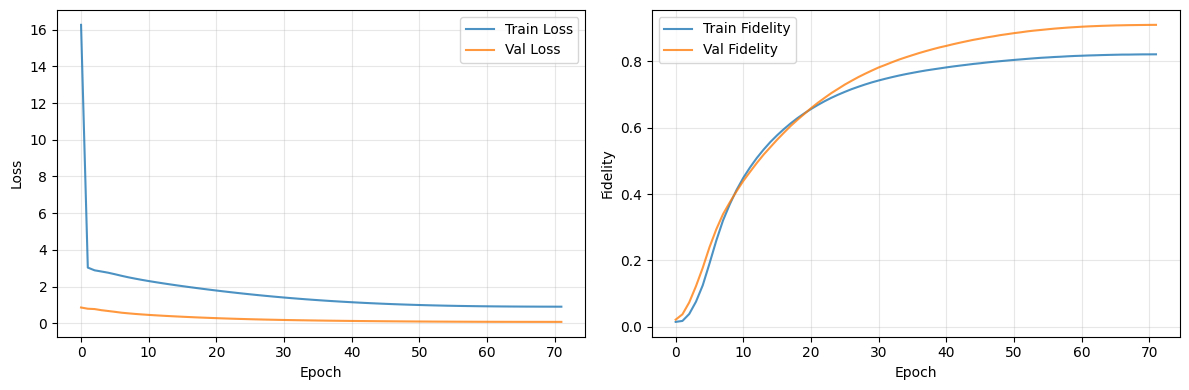

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)

trained_model = train_model(
    x_train, y_train, x_val, y_val,
    matrix_dim=STATE_DIM,
    epochs=72,
    batch_size=48,
    lr=1e-4,
)

### Eval

In [8]:
device = next(trained_model.parameters()).device

test_dataset = TensorDataset(
    torch.tensor(x_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

trained_model.eval()
total_loss = 0.0
total_fid = 0.0
total_samples = 0

with torch.no_grad():
    for bx, by in tqdm(test_loader, desc="Testing", leave=False):
        bx, by = bx.to(device), by.to(device)
        batch_size = bx.shape[0]

        pred = trained_model(bx, noise_level=torch.zeros(batch_size, device=device))
        pred = iterative_denoise(trained_model, bx, STATE_DIM, n_iterations=3, device=device)

        loss, metrics = diffusion_aware_loss(pred, by, STATE_DIM)
        total_loss += loss.item() * batch_size
        total_fid += metrics['fidelity'] * batch_size
        total_samples += batch_size

test_loss = total_loss / total_samples
test_fid = total_fid / total_samples
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Fidelity: {test_fid:.4f}")

Testing:   0%|          | 0/26 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Test Loss: 0.0502
Test Fidelity: 0.9378


In [ ]:
single_qubit_gates_cp = {k: cp.asarray(v.get()) for k, v in generator.single_qubit_gates.items()}
evaluate_model(trained_model, x_test, y_test, state_dim=STATE_DIM, measurement_settings=generator.measurement_settings, single_qubit_gates=single_qubit_gates_cp)
print()

NN Prediction:   0%|          | 0/26 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Denoising:   0%|          | 0/3 [00:00<?, ?it/s]

Building Pauli basis:   0%|          | 0/1024 [00:00<?, ?it/s]

Transfer matrix (settings):   0%|          | 0/243 [00:00<?, ?it/s]

MLE Tomography:   0%|          | 0/200 [00:00<?, ?it/s]

Computing metrics:   0%|          | 0/4 [00:00<?, ?it/s]


--------------------------------------------------------------------------------------------------------------------------------
Quantum State Tomography - Comparison
--------------------------------------------------------------------------------------------------------------------------------
Method             Fidelity   ±Std     Min      RMSE       Time(s)  Samp/s  
--------------------------------------------------------------------------------------------------------------------------------
Neural Network     0.9339     0.0032   0.9224   0.0091     6.341    129.3   
Least Squares      0.3500     0.0468   0.2184   0.0101     0.640    1280.5  
Max Likelihood     0.1320     0.0332   0.0510   0.0147     655.785  1.3     
Linear Inversion   0.2490     0.0385   0.1427   0.0108     0.294    2789.0  

----------------------------------------------------------------
Statistical Tests (NN vs Classical)
----------------------------------------------------------------
NN vs Least Squares   

{'Neural Network': {'mean_fidelity': 0.93388134,
  'std_fidelity': 0.003200751,
  'min_fidelity': 0.92243487,
  'median_fidelity': 0.93407035,
  'mse': 8.198413e-05,
  'rmse': 0.009054509,
  'execution_time': 6.34127950668335,
  'samples_per_second': 129.31144245191626,
  'fidelities_array': array([0.93668586, 0.93112546, 0.9338725 , 0.9348787 , 0.9365012 ,
         0.9295744 , 0.9293193 , 0.9309149 , 0.93776333, 0.94110477,
         0.9365183 , 0.9273863 , 0.93150264, 0.9323763 , 0.9333568 ,
         0.9350469 , 0.9349687 , 0.9359937 , 0.93496484, 0.9353707 ,
         0.9334686 , 0.94095427, 0.9327092 , 0.9331109 , 0.9304183 ,
         0.93607384, 0.93424785, 0.93635404, 0.9323076 , 0.9366683 ,
         0.9387999 , 0.9302414 , 0.93663365, 0.9352285 , 0.9412391 ,
         0.93409044, 0.93137264, 0.9319159 , 0.9370713 , 0.93306535,
         0.93059164, 0.93638283, 0.93309134, 0.9388388 , 0.9323892 ,
         0.9336155 , 0.9367163 , 0.9295547 , 0.9345777 , 0.9375072 ,
         0.9313483 